In [1]:
import os
import pandas as pd
from am4pa.linnea import LinneaConfig, DataManagerLinnea
from algorithm_ranking import RankVariants
from algorithm_ranking import RankVariantsDFGTr,MeasurementsVisualizer
from variants_compare import VariantsCompare
from pm4py.objects.conversion.log import converter as log_converter
import statistics

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
linnea_config = LinneaConfig("gls.py")
exp_id = "GLS"
linnea_config.set_local_directory("codes/{}".format(exp_id))
linnea_config.setup_backend_details(server="login18-1.hpc.itc.rwth-aachen.de",
                                   uname = "as641651",
                                   init_script="~/.analyzer",
                                   backend_root="~/PhD/va4algs-exps/")
linnea_config.connect_backend()

In [3]:
dml = DataManagerLinnea(linnea_config)

{'problem': 'gls.py', 'backend': True, 'server': 'login18-1.hpc.itc.rwth-aachen.de', 'uname': 'as641651', 'local_dir': 'codes/GLS', 'backend_dir': '~/PhD/va4algs-exps/GLS'}


In [4]:
dml.operands_data

{'12T': ['1000_10',
  '1000_100',
  '1000_150',
  '1000_200',
  '1000_300',
  '100_1000']}

In [5]:
dml.measurements_data

{'12T': {'1000_10': ['1'],
  '1000_100': ['1', '2', '4'],
  '1000_150': ['1', '2', '4'],
  '1000_200': ['1', '2', '4'],
  '1000_300': ['1', '2', '4'],
  '100_1000': ['1', '2', '4']}}

In [16]:
dml.ranking_data

{'12T': [0.02]}

In [7]:
import pickle

def save_object(file_path,obj):
    with open(file_path,"wb") as f:
        pickle.dump(obj,f)

In [8]:
class RankingModel:
    def __init__(self):
        pass
    
    def train(self):
        pass
    
    def methodology2(self,alg_measurements,alg_list):
        rv = RankVariantsDFGTr(alg_measurements, alg_list)
        ranks =  rv.rank_variants_reliable()[0].iloc[:,:2]
        h0_ = rv.graph.get_separable_arrangement()
        return ranks,h0_
    
    def methodology3(self,alg_measurements,alg_list):
        pass
        
    def get_ranks(self,alg_measurements, alg_list=None):
        if not alg_list:
            alg_list = list(alg_measurements.keys())
        ## TODO ML model: decide methodolog2 or methodology3 and cutoff points
        ranks,h0_ = self.methodology2(alg_measurements,alg_list)    
        cutoffs = [0,0]
        return ranks, cutoffs, h0_
        

In [17]:
class RankingDataLinnea:
    def __init__(self, dml:DataManagerLinnea, rm:RankingModel, thread_str, rel_flops='all'):
        self.dml = dml
        self.rm = rm
        self.thread_str = thread_str
        
        self.data_vcs_flops = {}
        #self.data_vcs_nflops = {}
        #self.data_best_kseq = None
        #self.data_worst_kseq = None
        
        self.bfull_graphs = False
        self.data_kernels = None
        self.data_relations = None
        self.data_ext = None
        
        self.v_data_kernels = None
        self.v_data_relations = None
        self.v_data_ext = None
        
        self.f_data_kernels = None
        self.f_data_relations = None
        self.f_data_ext = None
        
        self.data_cutoffs = {}
        self.data_ranks = {}
        self.data_h0 = {}
        
        self.data_anomalies = None
        self.percent_anomalies = -1
        self.avg_risk = -1
        self.avg_adj_risk = -1
        
        self.rel_flops = rel_flops
        if not rel_flops == 'all':
            for op_str, ml in self.dml.mls[self.thread_str].items():
                ml.filter_on_flops(rel_flops)
                 
        
        self.obj_path = os.path.join(dml.lc.local_dir,'ranking-data','rdl_{}_{}.pkl'.format(thread_str,rel_flops))
        
        
    def rank3way(self):
                
        for op_str, ml in self.dml.mls[self.thread_str].items():
            
            #collect data
            ml.case_durations_manager.clear_case_durations()
            for i in self.dml.measurements_data[self.thread_str][op_str]:
                ml.collect_measurements(i)
                
            ranks,cutoffs,h0_ = self.rm.get_ranks(ml.get_alg_measurements())
            dc = ml.data_collector
            ct = ml.filter_table(dc.get_case_table())
            min_flop = ct['case:flops'].min()
            ct['case:rel-flops'] = ct.apply(lambda row: (row['case:flops'] - min_flop) / min_flop, axis=1)
            
            
            ranks = ranks.merge(ct, on='case:concept:name')
            self.data_ranks[op_str] = ranks
            self.data_h0[op_str] = h0_
            self.data_cutoffs[op_str] = cutoffs 

        self._determine_anomalies()
            
          
        
    def _determine_anomalies(self):
        anomalies = []
        
        d_nodes = []
        d_edges = []
        d_ext = []
        
        v_nodes = []
        v_edges = []
        v_ext = []
        
        f_nodes = []
        f_edges = []
        f_ext = []
        
        for op_str, ranks in self.data_ranks.items():
            num_algs = len(ranks)
            max_rel_flops = ranks['case:rel-flops'].max()
            
            rel0_algs = set(ranks[ranks['case:rel-flops']==0]['case:concept:name'])
            best_algs = set(ranks[ranks.iloc[:,1]<=self.data_cutoffs[op_str][0]]['case:concept:name'])
            rel_flops_cutoff = ranks[ranks.iloc[:,1]==0]['case:rel-flops'].min()
            
            n_rel0 = len(rel0_algs)
            anomaly_algs = rel0_algs - best_algs
            n_anomalies = len(anomaly_algs)
            risk = n_anomalies/float(n_rel0)
            
            data = [op_str,num_algs,max_rel_flops,
                     not rel0_algs.issubset(best_algs),
                     n_rel0,
                     n_anomalies,
                     risk]
            
            adj_risk = 0.0
            if n_anomalies > 0:
                ml = self.dml.mls[self.thread_str][op_str]
                
                am = ml.get_alg_measurements()
                
                tmp = [] 
                for alg in best_algs:
                    tmp.append(statistics.median(am[alg]))
                m_best = statistics.mean(tmp)
                
                tmp = [] 
                for alg in anomaly_algs:
                    tmp.append(statistics.median(am[alg]))
                    
                m_anomaly = statistics.mean(tmp)
                
                time_inc = m_anomaly - m_best
                rel_inc = time_inc/float(m_best)
                adj_risk = risk*rel_inc
                
                data.append(time_inc)
                data.append(rel_inc)
                data.append(adj_risk)
                
            else:
                data.append(0.0)
                data.append(0.0)
                data.append(0.0)
                           
            data.append(rel_flops_cutoff)
            anomalies.append(data) 
            
            if self.bfull_graphs:
                worst_algs = set(ranks[ranks.iloc[:,1]>self.data_cutoffs[op_str][1]]['case:concept:name'])
                dn,de,ext = self.prepare_dfg_data(op_str,list(best_algs),list(worst_algs))
                
                d_nodes.append(dn)
                d_edges.append(de)
                d_ext.append(ext)
                
            
            if adj_risk > 0.0 and rel_flops_cutoff == 0:
                best_v = best_algs.intersection(rel0_algs)
                worst_v = anomaly_algs
                
                dn,de,ext = self.prepare_dfg_data(op_str,list(best_v),list(worst_v))
                
                v_nodes.append(dn)
                v_edges.append(de)
                v_ext.append(ext)
                
            elif adj_risk > 0.0 and rel_flops_cutoff > 0.0:
                worst_v = set(ranks[ranks['case:rel-flops']<=rel_flops_cutoff]['case:concept:name']) - best_algs
                dn,de,ext = self.prepare_dfg_data(op_str,list(best_algs),list(worst_v))
                
                f_nodes.append(dn)
                f_edges.append(de)
                f_ext.append(ext)
                                          
            
        df = pd.DataFrame(anomalies,columns=['op_str', 'num_algs',
                                             'max-rel-flops','is_anomaly',
                                             'n_rel0','n_anomalies',
                                             'risk','time_inc',
                                             'rel_inc','adj_risk',
                                             'rel-flops-cutoff'])
        self.percent_anomalies = df['is_anomaly'].sum()/float(len(df['is_anomaly']))
        self.avg_risk = df['risk'].sum()/float(len(df['risk']))
        self.avg_adj_risk = df['adj_risk'].sum()/float(len(df['adj_risk']))
        
        self.data_anomalies = df
        
        if d_nodes:
            self.data_kernels = pd.concat(d_nodes).reset_index(drop=True)
            self.data_relations = pd.concat(d_edges).reset_index(drop=True)
            self.data_ext = pd.concat(d_ext).reset_index(drop=True)
            self.data_kernels, self.data_relations = self.prepare_kernel_relations_data(self.data_kernels,
                                                                                           self.data_relations)
                
        if v_nodes:
            self.v_data_kernels = pd.concat(v_nodes).reset_index(drop=True)
            self.v_data_relations = pd.concat(v_edges).reset_index(drop=True)
            self.v_data_ext = pd.concat(v_ext).reset_index(drop=True)
            self.v_data_kernels, self.v_data_relations = self.prepare_kernel_relations_data(self.v_data_kernels,
                                                                                            self.v_data_relations)
            
        if f_nodes:
            self.f_data_kernels = pd.concat(f_nodes).reset_index(drop=True)
            self.f_data_relations = pd.concat(f_edges).reset_index(drop=True)
            self.f_data_ext = pd.concat(f_ext).reset_index(drop=True)
            self.f_data_kernels, self.f_data_relations = self.prepare_kernel_relations_data(self.f_data_kernels,
                                                                                            self.f_data_relations)
        
    
    def get_adjusted_risk(self,op_str):
        if not self.data_anomalies:
            return -1
        
        xy = self.data_anomalies
        return xy.loc[xy['op_str']==op_str,'adj_risk'].values[0]
    
    def get_rel_flops_cutoff(self,op_str):
        if not self.data_anomalies:
            return -1
        
        xy = self.data_anomalies
        return xy.loc[xy['op_str']==op_str,'rel-flops-cutoff'].values[0]
    
    def prepare_dfg_data(self,op_str,best_a,worst_a):
        
        ml = self.dml.mls[self.thread_str][op_str]
        dc = ml.data_collector
        
        et = ml.filter_table(dc.get_meta_table())
        et['concept:name'] = et['concept:name'].apply(lambda row: self._clean_concept_eq(row))
        et['concept:name'] = et['concept:name'].apply(lambda row: self._clean_concept_remove_LAPACK(row))
        
        xes_log = log_converter.apply(et)

        activity_key = 'concept:name'
        vc = VariantsCompare(xes_log,best_a,worst_a,activity_key=activity_key)
        dn, de = vc.get_diff_data()
        dn['operands'] = op_str
        de['operands'] = op_str

        et = et.merge(self.data_ranks[op_str], on='case:concept:name')
        et['kernel'] = et.apply(lambda x: x['concept:name'].split('_')[0], axis=1)
        ext = et[['kernel', 'concept:flops', 'case:rel-flops']]
        ext = ext.drop_duplicates().reset_index(drop=True)
        
        self.data_vcs_flops[op_str] = vc
        
        return dn,de,ext
                     
    
    def prepare_kernel_relations_data(self,data_kernels,data_relations):
        def get_flops(str_):
            if not '@@' in str_:
                return float(str_.split('_')[1])
            return 0
        data_kernels['flops'] = data_kernels.apply(lambda x: get_flops(x['node']), axis=1)
        data_kernels['kernel'] = data_kernels.apply(lambda x: x['node'].split('_')[0], axis=1)
        data_relations['flopsA'] = data_relations.apply(lambda x: get_flops(x['nodeA']), axis=1)
        data_relations['kernelA'] = data_relations.apply(lambda x: x['nodeA'].split('_')[0], axis=1)
        data_relations['flopsB'] = data_relations.apply(lambda x: get_flops(x['nodeB']), axis=1)
        data_relations['kernelB'] = data_relations.apply(lambda x: x['nodeB'].split('_')[0], axis=1)
        
        return data_kernels, data_relations
    
    
    def _clean_concept_eq(self, name):
        splits = name.split('=')
        if len(splits) > 1:
            return splits[-1].strip()
        return splits[0].strip()
    
    def _clean_concept_remove_cost(self,name):
        splits = name.split('_')
        if len(splits) > 1:
            return splits[0].strip()
        return splits[0].strip()

    def _clean_concept_remove_LAPACK(self,name):
        splits = name.split('LAPACK.')
        if len(splits) > 1:
            return splits[-1].strip()
        return splits[0].strip()
    
    def visualize_box_plots(self, op_str, scale=0.8, tick_size=16):
        ml = self.dml.mls[self.thread_str][op_str]
        try:
            am = ml.get_alg_measurements()
            mv = MeasurementsVisualizer(am, self.data_h0[op_str])
            fig = mv.show_measurements_boxplots(scale=scale,tick_size=tick_size)
            return fig
        except TypeError:
            return -1
    
    
    def __getstate__(self):
        state = {
            'kernels':self.data_kernels,
            'relations':self.data_relations,
            'ext':self.data_ext,
            'v_kernels':self.v_data_kernels,
            'v_relations':self.v_data_relations,
            'v_ext':self.v_data_ext,    
            'f_kernels':self.f_data_kernels,
            'f_relations':self.f_data_relations,
            'f_ext':self.f_data_ext,
            'ranks':self.data_ranks,
            'h0':self.data_h0,
            'cutoffs':self.data_cutoffs,
            'vcs_f':self.data_vcs_flops,
            'anomalies':self.data_anomalies,
            'p_anomalies':self.percent_anomalies,
            'avg_risk':self.avg_risk,
            'avg_adj_risk':self.avg_adj_risk
        }
        return state
    
    def __setstate__(self,state):
        self.data_kernels = state['kernels']
        self.data_relations = state['relations']
        self.data_ext = state['ext']
        
        self.v_data_kernels = state['v_kernels']
        self.v_data_relations = state['v_relations']
        self.v_data_ext = state['v_ext']
        
        self.f_data_kernels = state['f_kernels']
        self.f_data_relations = state['f_relations']
        self.f_data_ext = state['f_ext']
        
        self.data_ranks = state['ranks']
        self.data_h0 = state['h0']
        self.data_vcs_flops = state['vcs_f']
        self.data_cutoffs = state['cutoffs']
        self.data_anomalies = state['anomalies']
        self.percent_anomalies = state['p_anomalies']
        self.avg_risk = state['avg_risk']
        self.avg_adj_risk = state['avg_adj_risk']
        
    def save(self):
        if not os.path.exists(os.path.dirname(self.obj_path)):
            os.makedirs(os.path.dirname(self.obj_path))
            
        with open(self.obj_path,"wb") as f:
            pickle.dump(self,f)
        
        try:
            if not self.rel_flops in self.dml.ranking_data[self.thread_str]:
                self.dml.ranking_data[self.thread_str].append(self.rel_flops)
        except KeyError:
            self.dml.ranking_data[self.thread_str] = [self.rel_flops]
        self.dml._update_json(self.dml.ranking_data,self.dml.ranking_data_file)
            
    def load(self,measurements=False):
        if not os.path.exists(self.obj_path):
            return -1
        
        with open(self.obj_path,"rb") as f:
            self.__setstate__(pickle.load(f).__getstate__())
            
        
        if measurements:
            for op_str, ml in self.dml.mls[self.thread_str].items():

                #collect data
                ml.case_durations_manager.clear_case_durations()
                for i in self.dml.measurements_data[self.thread_str][op_str]:
                    ml.collect_measurements(i)
        
    

In [42]:
dml = DataManagerLinnea(linnea_config)
rm = RankingModel()
rdl = RankingDataLinnea(dml,rm,'12T')

{'problem': 'gls.py', 'backend': True, 'server': 'login18-1.hpc.itc.rwth-aachen.de', 'uname': 'as641651', 'local_dir': 'codes/GLS', 'backend_dir': '~/PhD/va4algs-exps/GLS'}


In [43]:
#rdl.bfull_graphs = True
rdl.rank3way()

/Users/aravind/.local/lib/python3.9/site-packages/pm4py/utils.py:486: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


In [44]:
rdl.percent_anomalies,rdl.avg_risk,rdl.avg_adj_risk

(0.16666666666666666, 0.10101010101010101, 0.0447665515531935)

In [45]:
rdl.data_anomalies

,op_str,num_algs,max-rel-flops,is_anomaly,n_rel0,n_anomalies,risk,time_inc,rel_inc,adj_risk,rel-flops-cutoff
0,1000_10,96,0.002907,False,27,0,0.000000,0.00000,0.000000,0.000000,0.0
1,1000_100,100,0.047191,False,9,0,0.000000,0.00000,0.000000,0.000000,0.0
2,1000_150,100,0.047244,False,9,0,0.000000,0.00000,0.000000,0.000000,0.0
3,1000_200,100,0.140381,False,9,0,0.000000,0.00000,0.000000,0.000000,0.0
4,1000_300,100,0.246594,False,9,0,0.000000,0.00000,0.000000,0.000000,0.0
5,100_1000,100,0.022422,True,33,20,0.606061,0.00059,0.443189,0.268599,0.0


In [46]:
rdl.data_kernels

In [47]:
rdl.data_relations

In [48]:
rdl.v_data_kernels

,node,class,operands,flops,kernel
0,gemv_2e+05,0,100_1000,200000.0,gemv
1,potrf_3.33e+05,0,100_1000,333000.0,potrf
2,potrf_3.33e+08,0,100_1000,333000000.0,potrf
3,syrk_1e+08,0,100_1000,100000000.0,syrk
4,transpose_1,-1,100_1000,1.0,transpose
5,trsm_1e+07,0,100_1000,10000000.0,trsm
6,trsv_1e+04,0,100_1000,10000.0,trsv
7,trsv_1e+06,0,100_1000,1000000.0,trsv


In [164]:
rdl.v_data_relations

,nodeA,nodeB,class,operands,flopsA,kernelA,flopsB,kernelB
0,gemv_2e+05,potrf_3.33e+08,0,100_1000,200000.0,gemv,333000000.0,potrf
1,gemv_2e+05,syrk_1e+08,0,100_1000,200000.0,gemv,100000000.0,syrk
2,gemv_2e+05,trsm_1e+07,0,100_1000,200000.0,gemv,10000000.0,trsm
3,gemv_2e+05,trsv_1e+06,0,100_1000,200000.0,gemv,1000000.0,trsv
4,potrf_3.33e+05,trsm_1e+07,0,100_1000,333000.0,potrf,10000000.0,trsm
5,potrf_3.33e+05,trsv_1e+04,0,100_1000,333000.0,potrf,10000.0,trsv
6,potrf_3.33e+08,gemv_2e+05,0,100_1000,333000000.0,potrf,200000.0,gemv
7,potrf_3.33e+08,trsv_1e+04,0,100_1000,333000000.0,potrf,10000.0,trsv
8,potrf_3.33e+08,trsv_1e+06,0,100_1000,333000000.0,potrf,1000000.0,trsv
9,syrk_1e+08,gemv_2e+05,0,100_1000,100000000.0,syrk,200000.0,gemv


In [165]:
rdl.v_data_ext

,kernel,concept:flops,case:rel-flops
0,potrf,333000.0,0.0
1,trsm,10000000.0,0.0
2,trsv,10000.0,0.0
3,syrk,100000000.0,0.0
4,gemv,200000.0,0.0
5,potrf,333000000.0,0.0
6,trsv,1000000.0,0.0
7,transpose,1.0,0.0


In [166]:
rdl.data_ranks['1000_150']

,case:concept:name,case:rank:q75-q25,case:flops,case:num_kernels,case:rel-flops
0,algorithm3,0,508000000.0,8,0.000000
1,algorithm0,0,508000000.0,8,0.000000
2,algorithm5,0,508000000.0,8,0.000000
3,algorithm4,0,508000000.0,8,0.000000
4,algorithm1,0,508000000.0,8,0.000000
5,algorithm6,0,508000000.0,8,0.000000
6,algorithm7,0,508000000.0,8,0.000000
7,algorithm8,0,508000000.0,8,0.000000
8,algorithm2,0,508000000.0,8,0.000000
9,algorithm24,1,509000000.0,10,0.001969


In [167]:
#rdl.data_h0['1000_150']

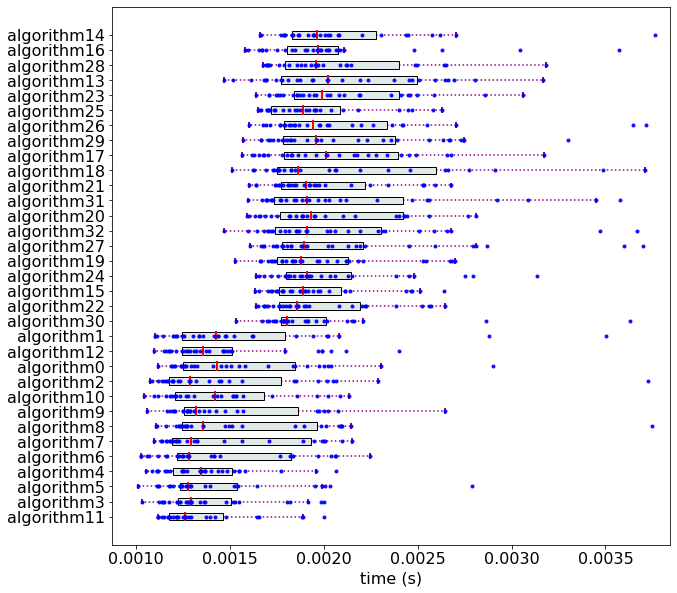

In [168]:
fig = rdl.visualize_box_plots('100_1000',scale=0.3)

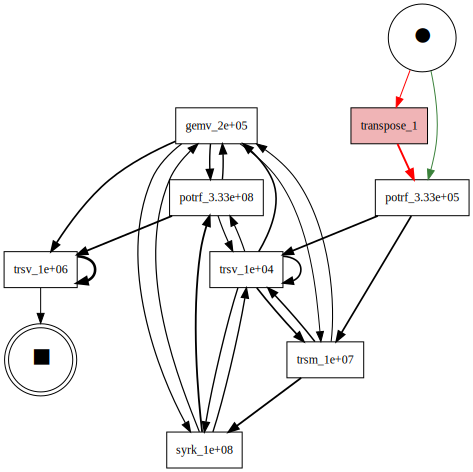

In [169]:
rdl.data_vcs_flops['100_1000'].get_dfg_minus_best_worst()

In [27]:
rdl.obj_path

'codes/GLS/ranking-data/rdl_12T_all.pkl'

In [49]:
rdl.save()

In [51]:
dml = DataManagerLinnea(linnea_config)
rdl_ = RankingDataLinnea(dml,rm,'12T',0.02)


{'problem': 'gls.py', 'backend': True, 'server': 'login18-1.hpc.itc.rwth-aachen.de', 'uname': 'as641651', 'local_dir': 'codes/GLS', 'backend_dir': '~/PhD/va4algs-exps/GLS'}


In [52]:
rdl_.data_kernels

In [53]:
rdl_.load()

In [54]:
rdl.avg_adj_risk

0.0447665515531935

In [33]:
rdl_.data_kernels

In [34]:
rdl_.data_ext

In [35]:
rdl_.v_data_kernels

,node,class,operands,flops,kernel
0,gemv_2e+05,0,100_1000,200000.0,gemv
1,potrf_3.33e+05,0,100_1000,333000.0,potrf
2,potrf_3.33e+08,0,100_1000,333000000.0,potrf
3,syrk_1e+08,0,100_1000,100000000.0,syrk
4,transpose_1,-1,100_1000,1.0,transpose
5,trsm_1e+07,0,100_1000,10000000.0,trsm
6,trsv_1e+04,0,100_1000,10000.0,trsv
7,trsv_1e+06,0,100_1000,1000000.0,trsv


In [152]:
fig = rdl_.visualize_box_plots('1000_150',scale=0.3)

In [154]:
rdl_.data_relations

In [156]:
rdl_.data_ranks['1000_150']

,case:concept:name,case:rank:q75-q25,case:flops,case:num_kernels,case:rel-flops
0,algorithm3,0,508000000.0,8,0.000000
1,algorithm0,0,508000000.0,8,0.000000
2,algorithm5,0,508000000.0,8,0.000000
3,algorithm4,0,508000000.0,8,0.000000
4,algorithm1,0,508000000.0,8,0.000000
5,algorithm6,0,508000000.0,8,0.000000
6,algorithm7,0,508000000.0,8,0.000000
7,algorithm8,0,508000000.0,8,0.000000
8,algorithm2,0,508000000.0,8,0.000000
9,algorithm24,1,509000000.0,10,0.001969


In [31]:
#rdl_.data_vcs_flops['1000_10'].get_dfg_minus_best_worst()

In [34]:
xx = rdl_.data_ranks['1000_150']

In [52]:
rel0_algs = set(xx[xx['case:rel-flops']==0]['case:concept:name'])

In [53]:
best_algs = set(xx[xx.iloc[:,1]==0]['case:concept:name'])

In [56]:
not rel0_algs.issubset(best_algs)

False

In [88]:
a = {1,2,3}
b = {1,2,4}

In [89]:
len(a-b)

1

In [97]:
l =[1,2,3]

In [100]:
statistics.mean(l)

2

In [123]:
xx[xx.iloc[:,1]==0]['case:rel-flops'].min()

0.0

In [155]:
xy = rdl_.data_anomalies

In [156]:
xy

,op_str,is_anomaly,n_rel0,n_anomalies,risk,time_inc,rel_inc,adj_risk,rel-flops-cutoff
0,1000_10,False,27,0,0.000000,0.00000,0.000000,0.000000,0.0
1,1000_100,False,9,0,0.000000,0.00000,0.000000,0.000000,0.0
2,1000_150,False,9,0,0.000000,0.00000,0.000000,0.000000,0.0
3,1000_200,False,9,0,0.000000,0.00000,0.000000,0.000000,0.0
4,1000_300,False,9,0,0.000000,0.00000,0.000000,0.000000,0.0
5,100_1000,True,33,20,0.606061,0.00059,0.443189,0.268599,0.0


In [161]:
xy.loc[xy['op_str']=='1000_10','adj_risk'].values[0]

0.0

In [176]:
cc = []
if cc:
    print("x")